# Predict and evaluate SkillsColBERT

In [25]:
# install
# !pip install pytorch-pretrained-bert pytorch-nlp keras scikit-learn matplotlib tensorflow

#https://towardsdatascience.com/bert-for-dummies-step-by-step-tutorial-fb90890ffe03 

## Questions:

    a) Dimensions of max function in MaxSim method function.
        - max of column vectors in matrix OR max of row vectors in columns --> 24 dimensional
    b) Training of my ColBERT model
        - [Q] and [D] in vocabulary --> Drop
        - Weights in additional linear layer of 32
        - [MASK] as padding instead of [PAD]
    c) How to save:
        The model (in github) --> Drop
        The document embeddings
        


In [1]:
# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

UsageError: Line magic function `%` not found.


In [2]:
# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device=="cuda":
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)
    print(f'Running on {device} with {n_gpu} number of GPUs')
else:
    print(f'Running on {device}. Be patient...')

Running on cpu. Be patient...


# Import model
Queries and documents have now been tokenized to the vocabolary

In [3]:
from transformers import BertConfig
from transformers import BertModel

model_path = r'J:\VOA\MABI\Deep Learning\my_DTU_project\Models\danish_bert_uncased_v2'
#model_path = r'J:\VOA\MABI\Kompetence\kompetenceprojekt\star-kompetencemodel\models\kategorisering'

config_path = r'\bert_config.json'
#config_path = r'\config.json'

config = BertConfig.from_pretrained(model_path + config_path)
bert_base = BertModel(config)

#param_optimizer = list(bert_base.named_parameters())
#print(bert_base)

In [5]:
from torch import nn
import torch.nn.functional as F

class SkillsColBERT(nn.Module):
    def __init__(self):
          super(SkillsColBERT, self).__init__()
          self.bert = bert_base 
          ### New layers:
          #TODO: 
          # self.finalLinear = nn.Linear(768, 32) # 32 is "low" for faster computation of MaxSim (it is independent of sequence lentgh)
          

    def forward(self, ids, mask):
          sequence_output, pooled_output = self.bert(ids, attention_mask=mask) # sequence_output shape is: (batch_size, sequence_length, 768)
               
          # We apply the linear layer in line with ColBERT paper. The linear layer (which applies a linear transformation)
          # takes as input the hidden states of all tokens (so seq_len times a vector of size 768, each corresponding to
          # a single token in the input sequence) and outputs 32 numbers for every token
          # so the logits are of shape (batch_size, sequence_length, 32)
          
          #TODO: 
          # sequence_output = self.finalLinear(sequence_output)
          sequence_output = F.softmax(sequence_output, dim=1)

          return sequence_output

#model = SkillsColBERT()
#model

## Load Query and Document embeddings

In [6]:
# Embeddin#gs of queries
q_outputs = torch.load(f'./query_embeddings/query_tensor.pt') 
#q_outputs = torch.load(f'./query_embeddings/tensor_1.pt') 

# Embeddings of documents
d_outputs = torch.load(f'./doc_embeddings/doc_tensor.pt')
#d_outputs = torch.load(f'./doc_embeddings/tensor_1.pt')

q_outputs = q_outputs.to(device)
d_outputs = d_outputs.to(device)

print('Query embedding size:    ', q_outputs.shape) 
print('Document embedding size: ', d_outputs.shape) 

Query embedding size:     torch.Size([13485, 24, 768])
Document embedding size:  torch.Size([13485, 128, 768])


In summary, given a query sequence $q = q_0 q_1...q_l$ and a document sequence $d = d_0 d_1...d_n$, we compute the bags of embeddings $E_q$ and $E_d$ in the following manner:

* $E_q$ := Normalize( CNN( BERT(“[Q]$q_0 q_1...q_l$ ##...#”) ) )

* $E_d$ := Normalize( CNN( BERT(“[D]$d_0 d_1...d_l$ ...d_n”) ) )

where '#' refers to the [mask] tokens. 

In my implementation of BERT the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [24 \times 768] \\
    dim(E_d) = [ 128 \times 768]
\end{align*}

but with ColBert the last dimension is reduced to 32 by an additional linear layer, such that my implementation of ColBERT, the output dimensions are as follow:
\begin{align*}
    dim(E_q) = [24 \times 32] \\
    dim(E_d) = [ 128 \times 32]
\end{align*}

In practice the MaxSim score is implemented such that 1 query is evaluated against all ducuments. Therefore the relevant dimensions are:
\begin{align*}
    dim(E_q) = [24 \times 32] \\
    dim(E_D) = [13.485 \times 128 \times 32]
\end{align*}
where 32 is 768 if standard BERT embeddings are used.


### The relevancy score, MaxSim, is defined as follows:
$$ S_{q,d} = \sum_{i \in ||E_q||} \max_{j \in ||E_d||} E_{q_i} * E_{d_j}^T$$

In [7]:
def MaxSim(q, D):
    '''Takes in the embeddings of a query, q, and all documents' embeddings, D.
        Return a tensor of the query's similarity scores to all documents in D.'''

    # repeat q for faster matrix multiplication (faster than loop)
    batch_size=D.shape[0]
    q_X = q.repeat(batch_size, 1, 1)
    
    # multiply the same query q against all documents (in D)
    batch_mm = torch.bmm(q_X, D.permute(0,2,1))
    
    maks, _ = torch.max(batch_mm, dim=2) # dim=1 or dim=2
    #print(maks.shape) # should be (batch_size, 24)
    
    # Sum over maximum values --> return vector of length len(D)
    S_qD = torch.sum(maks, dim=1)
    
    return S_qD

In [8]:
def MinEuc(q, D):
    '''Takes in the embeddings of a query, q, and all documents' embeddings, D.
        Return a tensor of the query's similarity scores to all documents in D.'''
    
    # Euclidean distance between query q against all documents (in D)
    EucDist = torch.cdist(q, D, p=2, compute_mode = 'use_mm_for_euclid_dist_if_necessary')
    
    mini, _ = torch.min(EucDist, dim=2) # dim=1 or dim=2
    #print(mini.shape) # should be (batch_size, 24)
    
    # Sum over minimum values --> return vector of length len(D)
    S_qD = torch.sum(mini, dim=1)
    
    return S_qD

In [9]:
######## DIMENSION CHECK ########
n = 0     # query number
m = 57    # document number

# one query vs one document
batch_mm = torch.cdist(q_outputs[n], d_outputs[m])
mini, _ = torch.min(batch_mm, dim=1) # dim=1 or dim=2
single = torch.sum(mini, dim=0)
print('single: ', single)

# one query vs all documents
batch_mm = torch.cdist(q_outputs[n], d_outputs)
mini, _ = torch.min(batch_mm, dim=2) # dim=1 or dim=2
S_qD = torch.sum(mini, dim=1)
print('multi: ', batch_mm.shape)

print('multi: ', S_qD[n])

# MinEuc function query vs all documents
print('MinEuc: ', MinEuc(q_outputs[n], d_outputs)[m])

single:  tensor(28.2754, grad_fn=<SumBackward1>)
multi:  torch.Size([13485, 24, 128])
multi:  tensor(28.2337, grad_fn=<SelectBackward>)
MinEuc:  tensor(28.2754, grad_fn=<SelectBackward>)


## MaxSim implementation

In [ ]:
# set sample size, i.e. number of queries to calculate MaxSim score
sample_size = q_outputs.shape[0] # 100

most_similar_doc_score = []
most_similar_docID = []

 # Define D as all documents:
D = d_outputs[:sample_size]

for q_no in tqdm(range(sample_size)):
    
    # Select one query
    q = q_outputs[q_no]

    # Compute similarity scores for all 
    #S_qD = MaxSim(q, D)
    S_qD = MaxSim(q, D)
    maks, maks_id = torch.max(S_qD, dim=0)

    most_similar_doc_score.append(float(maks))
    most_similar_docID.append(int(maks_id))

100%|██████████| 100/100 [00:01<00:00, 54.46it/s]


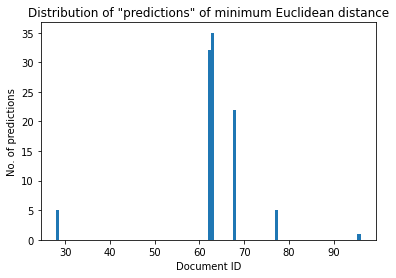

In [ ]:
# Distribution of "predictions"
plt.hist(most_similar_docID, bins=D.shape[0])
plt.title('Distribution of "predictions" of minimum Euclidean distance')
plt.xlabel('Document ID')
plt.ylabel('No. of predictions')
plt.show()

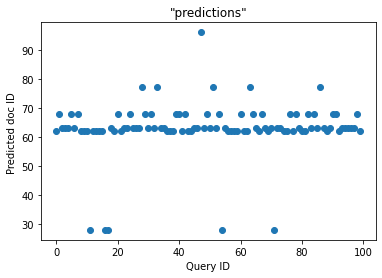

In [ ]:
# Distribution of "predictions"
q_IDs = [x for x in range(sample_size)]
plt.scatter(q_IDs, most_similar_docID)
plt.title('"predictions"')
plt.xlabel('Query ID')
plt.ylabel('Predicted doc ID ')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
y_true = q_IDs
y_pred = most_similar_docID

print('f_1score: ', round(f1_score(y_true, y_pred, average='macro'),4))

f_1score:  0.0006


In [ ]:
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs),3)}% accuracy')

rights: 1 out of 100 
 0.01% accuracy


In [45]:
df_correct = df.iloc[:sample_size,:].loc[(np.array(y_true) == np.array(y_pred))]
df_correct

NameError: name 'df' is not defined

In [81]:
# Inspect specific document. - Why are 49 and 79 getting this many hits. 
df.documents[79]

'Overvåge og vedligeholde boringsvæskerne eller "mudder". Tilføje forskellige kemikalier til væsken med henblik på at udføre forskellige funktioner i brøndoperationer: holde borebitten afkølet, hydrostatisk tryk, osv.'

## Example of implementation of MINIMUM Eucledian distance

In [10]:
# set sample size, i.e. number of queries to calculate MaxSim score
sample_size = q_outputs.shape[0] # 100

most_similar_doc_score = []
most_similar_docID = []

 # Define D as all documents:
D = d_outputs[:sample_size]

for q_no in tqdm(range(sample_size)):
    
    # Select one query
    q = q_outputs[q_no]

    # Compute similarity scores for all 
    #S_qD = MaxSim(q, D)
    S_qD = MinEuc(q, D)
    mini, mini_id = torch.min(S_qD, dim=0)

    most_similar_doc_score.append(float(mini))
    most_similar_docID.append(int(mini_id))

  1%|          | 161/13485 [6:02:59<846:12:05, 228.63s/it]

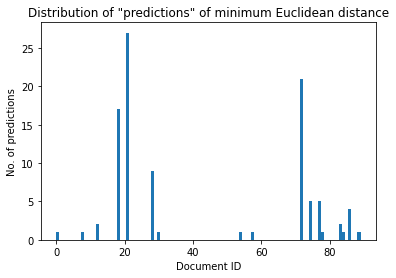

In [ ]:
# Distribution of "predictions"
plt.hist(most_similar_docID, bins=D.shape[0])
plt.title('Distribution of "predictions" of minimum Euclidean distance')
plt.xlabel('Document ID')
plt.ylabel('No. of predictions')
plt.show()

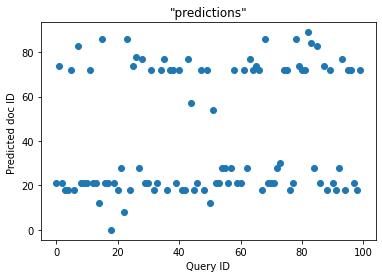

In [ ]:
# Distribution of "predictions"
q_IDs = [x for x in range(sample_size)]
plt.scatter(q_IDs, most_similar_docID)
plt.title('"predictions"')
plt.xlabel('Query ID')
plt.ylabel('Predicted doc ID ')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
y_true = q_IDs
y_pred = most_similar_docID

print('f_1score: ', round(f1_score(y_true, y_pred, average='macro'),4))

f_1score:  0.0


In [ ]:
rights = sum(np.array(y_true) == np.array(y_pred))
wrongs = sum(np.array(y_true) != np.array(y_pred))

print(f'rights: {rights} out of {rights+wrongs} \n {np.round(rights/(rights+wrongs),3)}% accuracy')

rights: 0 out of 100 
 0.0% accuracy


## Benchmark
BERCH embedding Euclidean distance